In [179]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
from TM1py import TM1Service

In [264]:
with TM1Service(address="xxx.xxx.xxx.xxx", port=16319, user="admin", password="apple", ssl=True) as tm1:
    data = tm1.power_bi.execute_view(cube_name="TCP_TRAVEL_COST_PREDICTION", view_name="travel_costs_prediction_dataset", private=False)

In [265]:
# combine and convert the years and months to a single value
data["TCP_DATE"] = pd.to_datetime(data["TCP_YEAR"] +"-"+ data["TCP_MONTH"]+"-01")

# convert EUR to numeric
data['COSTS'] = pd.to_numeric(data['COSTS'], errors='coerce')

# drop unimportant columns
data = data.drop(['TCP_YEAR', 'TCP_MONTH'], axis=1)

# reindex columns
data = data.reindex(columns=['TCP_DATE','COSTS'])

# reindex
data.set_index('TCP_DATE', inplace=True)

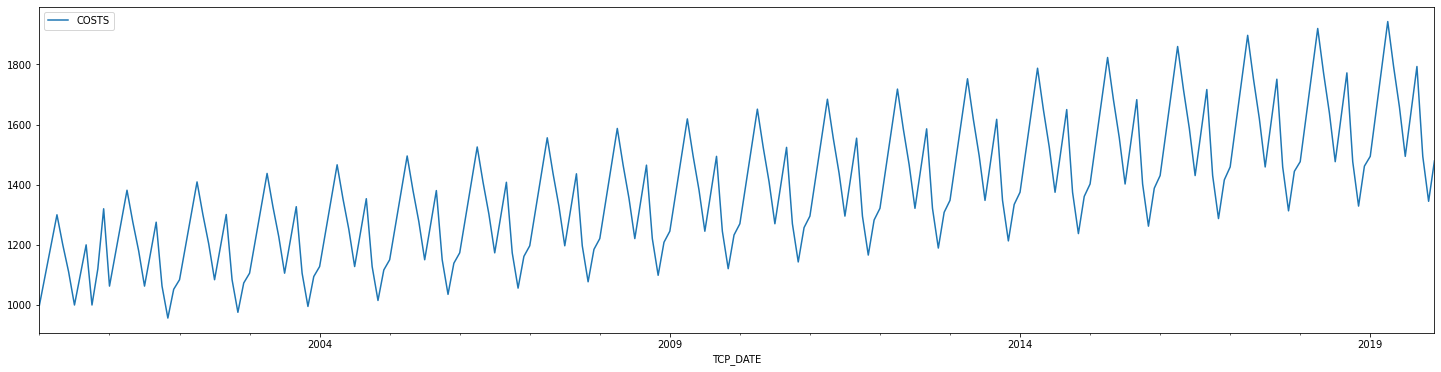

In [266]:
 data.plot(figsize=(25, 6))

In [267]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [268]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4142.070380140943
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3661.9405841058756
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2274.8185032946185
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1923.584012710318
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2126.8684652309767
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2117.0580340278034
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1872.1977593088568
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1728.9214323869394
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3825.63982480514
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3365.3577400390186
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2098.1934846892996
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1747.2139974515255
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2031.7617822455811
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2019.1525133436642
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1693.299014735995
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1492.7708259305286
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3025.2828715350406
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2607.42783256158

In [269]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4438      0.260     -1.708      0.088      -0.953       0.065
ma.L1          0.6463      0.220      2.935      0.003       0.215       1.078
ar.S.L12      -0.0174      0.004     -4.046      0.000      -0.026      -0.009
ma.S.L12       1.1845      0.050     23.482      0.000       1.086       1.283
sigma2         2.1521      0.267      8.057      0.000       1.629       2.676


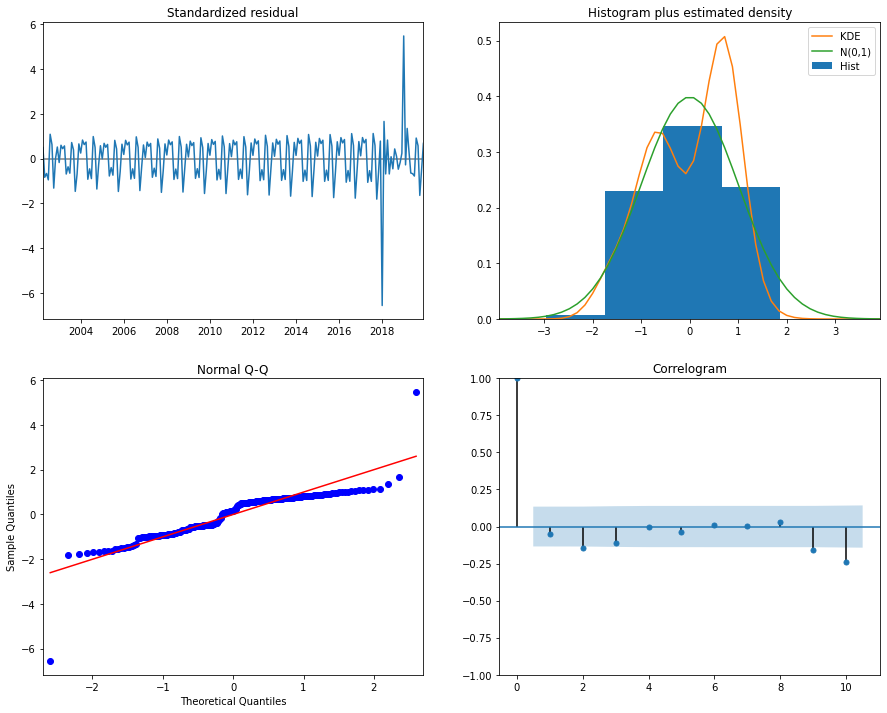

In [270]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [271]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

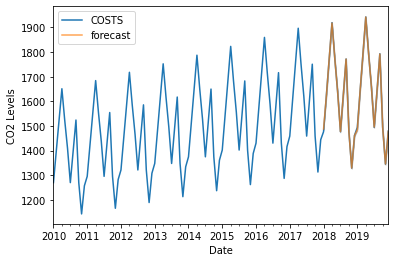

In [272]:
ax = data['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

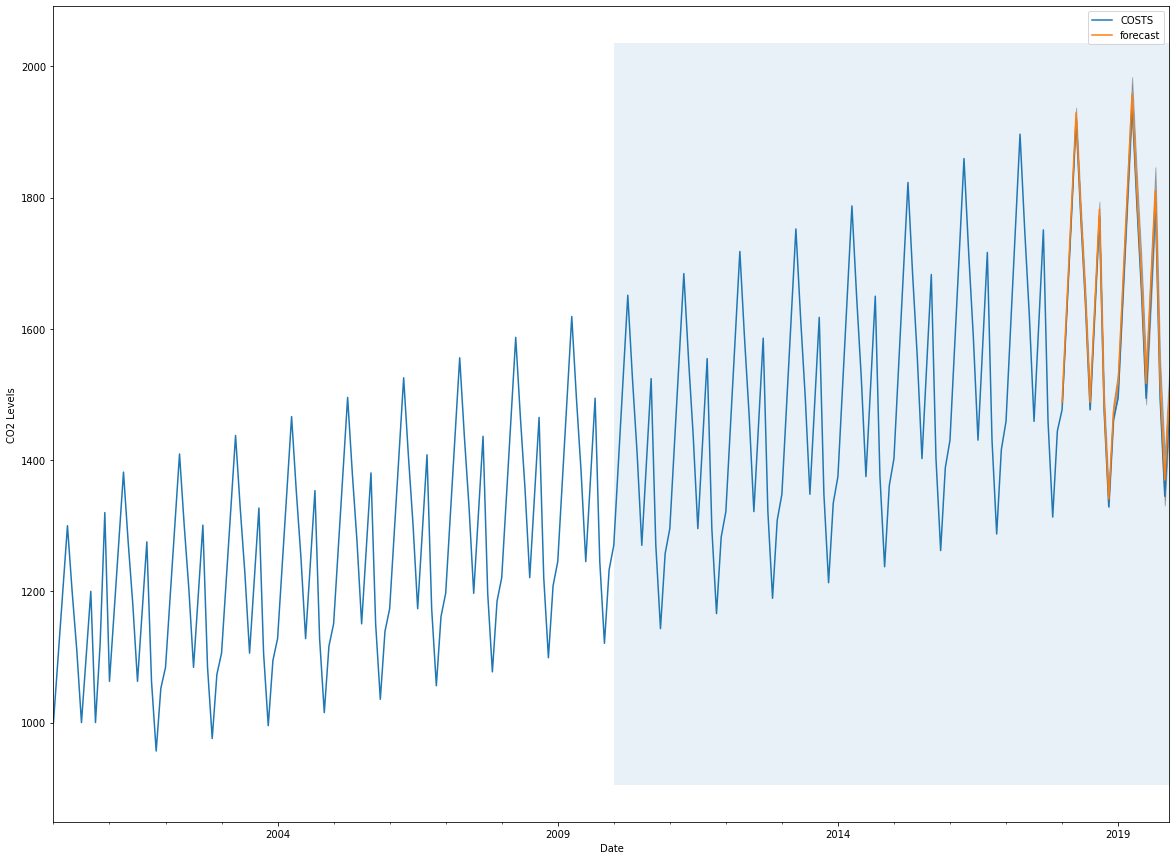

In [273]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = data['2000':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2010-01-01'), data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [274]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

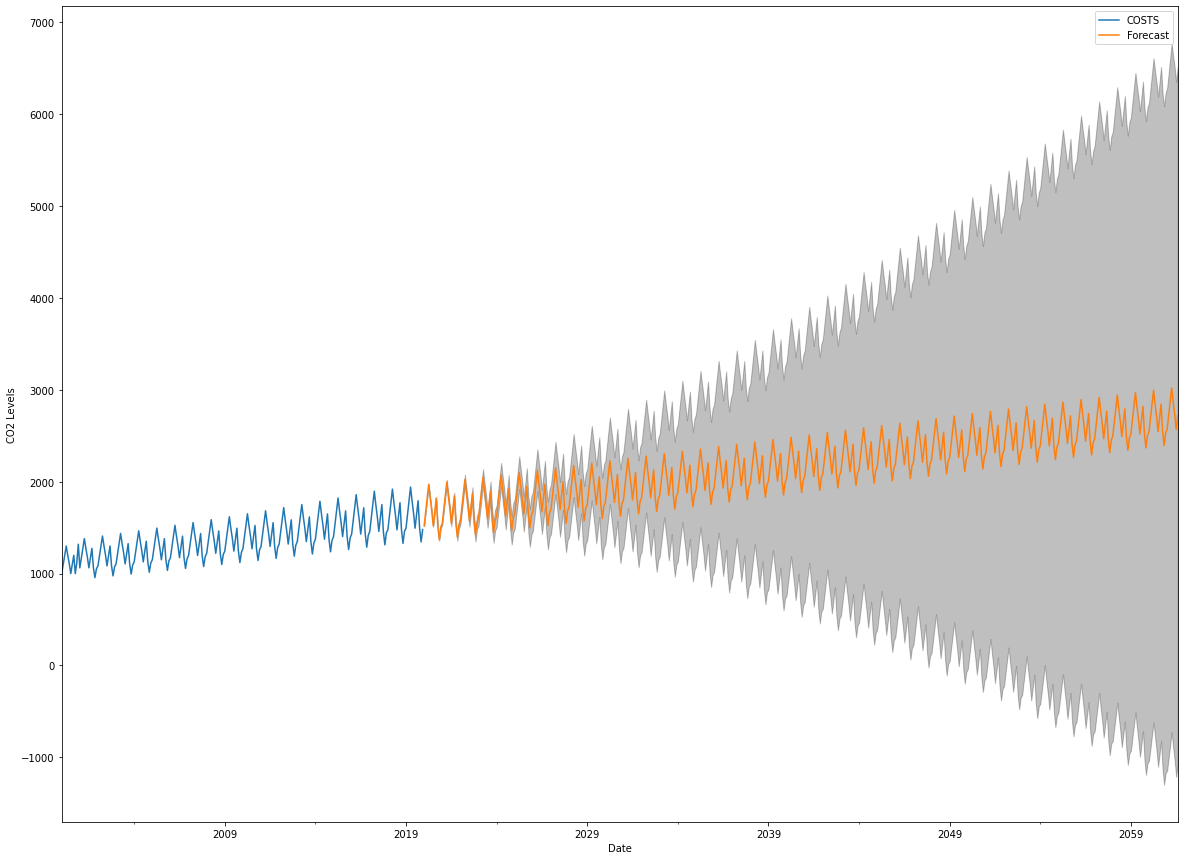

In [276]:
ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [277]:
pred_uc.predicted_mean

2020-01-01    1520.106520
2020-02-01    1670.599119
2020-03-01    1821.221729
2020-04-01    1971.787983
2020-05-01    1821.212371
                 ...     
2061-04-01    3021.862359
2061-05-01    2871.312882
2061-06-01    2735.798276
2061-07-01    2570.181303
2061-08-01    2720.743398
Freq: MS, Length: 500, dtype: float64

In [298]:
# Declare the cellset
cellset = {}
# Prepare the cellset
for row in pred_uc.predicted_mean.index:
    cellset[(str(row.year), str(row.month).zfill(2), 'PREDICTION1', 'CUSTOMERS','COSTS')] = pred_uc.predicted_mean[row]

In [302]:
cellset

72,
 ('2039', '01', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2006.8042410173923,
 ('2039', '02', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2157.204983877337,
 ('2039', '03', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2307.839732005585,
 ('2039', '04', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2458.3719525368933,
 ('2039', '05', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2307.822475431346,
 ('2039', '06', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2172.3078696190787,
 ('2039', '07', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2006.690896654383,
 ('2039', '08', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2157.2529923600755,
 ('2039', '09', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2307.817469220876,
 ('2039', '10', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2006.673683988142,
 ('2039', '11', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 1856.0891193850287,
 ('2039', '12', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 1991.6022975256828,
 ('2040', '01', 'PREDICTION1', 'CUSTOMERS', 'COSTS'): 2032.417441294758,
 ('2040', '02', 'PREDICTION1', 'CUSTOMERS

In [301]:
with TM1Service(address="10.25.0.218", port=16319, user="admin", password="apple", ssl=True) as tm1:
    tm1.cubes.cells.write_values('TCP_TRAVEL_COST_PREDICTION', cellset)